<center>
<h1> Linear Regression Case Study
</center>

### Steps for Regression Modeling:
1. Business problem definition - One of major automobile company would like to design new product which can improve the sales. Inorder to define the product, they want to understand/identify drivers for the sales (what are the factors driving sales) and Predicting sales of different car models given driving factors. 
2. Convert business problem into statistical problem  sales = F(sales attributes, product features, marketing info etc.)
3. Finding the right technique - Since it is predicting value (Regression Problem) problem so we can use OLS as one of the technique. We can also use other techniques like Decision Trees, Ensemble learning, KNN, SVM, ANN etc.
4. Data colletion(Y, X) - Identify the sources of information and collect the data
5. Consolidate the data - aggregate and consolidate the data at Model level/customer level/store level depends on business problem
6. Data preparation for modeling (create data audit report to identify the steps to perform as part of data preparation)
    a. missing value treatment
    b. outlier treatment
    c. dummy variable creation
7. Variable creation by using transformation and derived variable creation.
8. Basic assumptions (Normality, linearity, no outliers, homoscadasticity, no pattern in residuals, no auto correlation etc)
9. Variable reduction techniques (removing multicollinerity with the help of FA/PCA, correlation matrics, VIF)
10. Create dev and validation data sets (50:50 if you have more data else 70:30 or 80:20)
11. Modeling on dev data set (identify significant variables, model interpretation, check the signs and coefficients, multi-collinierity check, measures of good neess fit, final mathematical equation etc)
12. validating on validation data set (check the stability of model, scoring, decile analysis, cross validation etc.)
13. Output interpretation and derive insights (understand the limitations of the model and define strategy to implementation)
14. convert statistical solution into business solutions (implementation, model monitoring etc)


### import the packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as stats

In [2]:
# pip install pandas_profiling
import pandas_profiling

In [6]:
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### create UDFs

In [31]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.dtype, x.nunique(), x.count(), x.isnull().sum(), x.sum(), x.mean(),
                      x.median(), x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
            index = ['DataType', 'C', 'N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 
                           'P1', 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [34]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.nunique(), x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['C', 'N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [9]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [12]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### import data

In [13]:
cars = pd.read_csv('D:/Sampledata/Car_sales.csv')

### data inspection

In [14]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
Manufacturer              157 non-null object
Model                     157 non-null object
Sales_in_thousands        157 non-null float64
four_year_resale_value    121 non-null float64
Vehicle_type              157 non-null object
Price_in_thousands        155 non-null float64
Engine_size               156 non-null float64
Horsepower                156 non-null float64
Wheelbase                 156 non-null float64
Width                     156 non-null float64
Length                    156 non-null float64
Curb_weight               155 non-null float64
Fuel_capacity             156 non-null float64
Fuel_efficiency           154 non-null float64
Latest_Launch             157 non-null object
Power_perf_factor         155 non-null float64
dtypes: float64(12), object(4)
memory usage: 19.7+ KB


In [21]:
cars.Manufacturer.unique()

array(['Acura', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet',
       'Chrysler', 'Dodge', 'Ford', 'Honda', 'Hyundai', 'Infiniti',
       'Jaguar', 'Jeep', 'Lexus', 'Lincoln', 'Mitsubishi', 'Mercury',
       'Mercedes-B', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac',
       'Porsche', 'Saab', 'Saturn', 'Subaru', 'Toyota', 'Volkswagen',
       'Volvo'], dtype=object)

In [10]:
# profiling using pandas profiling
report = pandas_profiling.ProfileReport(cars)

In [12]:
# export the file as html
# screen the variables to get rid of unuseful variable sin the begining or
# make a note of potential variables for model refinement
report.to_file(output_file = 'profilereport.html')

In [13]:
# type conversion in case variables are not of proper type : Not required in this data

In [23]:
# seperate categorical and continuous variables
cars_conti_vars = cars.loc[:, (cars.dtypes == 'float64') | (cars.dtypes == 'int64')]
cars_cat_vars = cars.loc[:, (cars.dtypes == 'object')]

# Simper way of doing:
# cars_conti_vars = cars.select_dtypes(include = ['float64', 'int64'])
# car_sales_cat = cars.select_dtypes(include = ['object'])

In [25]:
cars_conti_vars.columns

Index(['Sales_in_thousands', 'four_year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length',
       'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor'],
      dtype='object')

In [26]:
cars_cat_vars.columns

Index(['Manufacturer', 'Model', 'Vehicle_type', 'Latest_Launch'], dtype='object')

In [32]:
# alternate of .describe() for continuous variables
cars_conti_vars.apply(continuous_var_summary).round(1)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
DataType,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
C,157,117,152,31,66,88,78,127,147,55,20,154
N,157,121,155,156,156,156,156,156,155,156,154,155
NMISS,0,36,2,1,1,1,1,1,2,1,3,2
SUM,8320.7,2186.83,4245.57,477.5,29008,16768,11099.4,29225.6,523.594,2800.5,3672,11941.8
MEAN,52.9981,18.073,27.3908,3.0609,185.949,107.487,71.15,187.344,3.37803,17.9519,23.8442,77.0436
MEDIAN,29.45,14.18,22.799,3,177.5,107,70.55,187.9,3.342,17.2,24,72.0309
STD,68.0294,11.4534,14.3517,1.04465,56.7003,7.6413,3.45187,13.4318,0.630502,3.88792,4.28271,25.1427
VAR,4628,131.18,205.97,1.0913,3214.93,58.3895,11.9154,180.412,0.397532,15.1159,18.3416,632.154
MIN,0.11,5.16,9.235,1,55,92.6,62.6,149.4,1.895,10.3,15,23.2763


In [35]:
# alternate of .describe() for categorical variables
cars_cat_vars.apply(categorical_var_summary)

,Manufacturer,Model,Vehicle_type,Latest_Launch
C,30,156,2,130
N,157,157,157,157
NMISS,0,0,0,0
MODE,Ford,Neon,Passenger,11/14/2011
FREQ,11,2,116,2
PERCENT,7.01,1.27,73.89,1.27


### outlier treatment

In [36]:
cars_conti_vars = cars_conti_vars.apply(lambda x: x.clip(lower = x.quantile(0.01), 
                                                         upper = x.quantile(0.99)))

In [37]:
cars_conti_vars.apply(continuous_var_summary).round(1)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
DataType,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
C,155,115,150,29,64,87,76,125,145,54,19,152
N,157,121,155,156,156,156,156,156,155,156,154,155
NMISS,0,36,2,1,1,1,1,1,2,1,3,2
SUM,8025.53,2180.42,4235.96,475.81,28910.3,16760.1,11102.5,29223.9,523.77,2799.9,3660,11911.7
MEAN,51.118,18.02,27.3287,3.05006,185.322,107.437,71.1696,187.333,3.37916,17.9481,23.7662,76.8496
MEDIAN,29.45,14.18,22.799,3,177.5,107,70.55,187.9,3.342,17.2,24,72.0309
STD,57.7227,11.1813,14.064,0.982279,52.8165,7.4243,3.39034,13.1204,0.621764,3.81985,3.99476,23.845
VAR,3331.91,125.022,197.795,0.964871,2789.58,55.1202,11.4944,172.144,0.386591,14.5913,15.9581,568.582
MIN,0.93728,6.173,10.2314,1.555,96.4,92.875,66.085,154.915,2.2454,11.9,15,38.4619


### missing value treatment

In [38]:
cars_conti_vars = cars_conti_vars.apply(missing_imputation)
cars_cat_vars = cars_cat_vars.apply(missing_imputation)

In [39]:
cars_conti_vars.apply(continuous_var_summary).round(1)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
DataType,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
C,155,116,151,30,65,88,77,126,146,55,20,153
N,157,157,157,157,157,157,157,157,157,157,157,157
NMISS,0,0,0,0,0,0,0,0,0,0,0,0
SUM,8025.53,2829.14,4290.61,478.86,29095.6,16867.5,11173.6,29411.3,530.528,2817.85,3731.3,12065.4
MEAN,51.118,18.02,27.3287,3.05006,185.322,107.437,71.1696,187.333,3.37916,17.9481,23.7662,76.8496
MEDIAN,29.45,17.71,23.4,3,180,107,70.6,187.8,3.368,17.2,24,72.2904
STD,57.7227,9.80668,13.9735,0.979125,52.6469,7.40046,3.37946,13.0782,0.617766,3.80759,3.95616,23.6916
VAR,3331.91,96.171,195.259,0.958686,2771.7,54.7668,11.4207,171.04,0.381634,14.4978,15.6512,561.293
MIN,0.93728,6.173,10.2314,1.555,96.4,92.875,66.085,154.915,2.2454,11.9,15,38.4619


## Handling categorical features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

In [40]:
def count_charts(x):
    sns.countplot(x)
    plt.show()

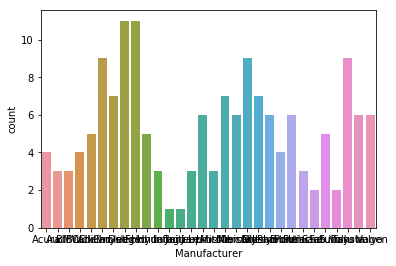

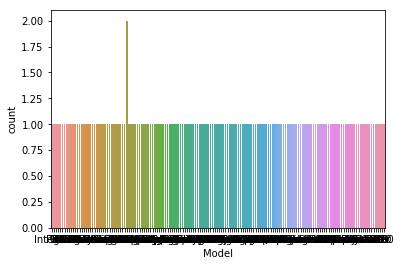

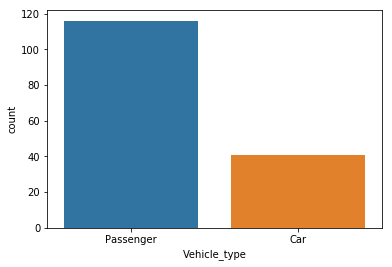

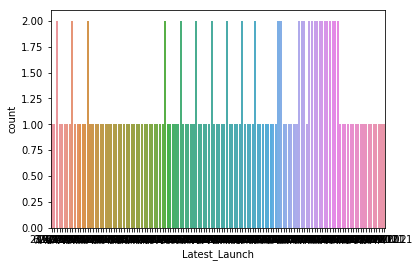

Manufacturer     None
Model            None
Vehicle_type     None
Latest_Launch    None
dtype: object

In [41]:
cars_cat_vars.apply(count_charts)

In [21]:
# get the count of all the categories of the variable
cars_cat_vars.Manufacturer.value_counts().count()

30

In [52]:
# get the useful categorical variables
cars_cat_vars = cars[['Manufacturer', 'Vehicle_type']]

# for c_feature in categorical_features
for c_feature in ['Manufacturer', 'Vehicle_type']:
    cars_cat_vars[c_feature] = cars_cat_vars[c_feature].astype('category')
    cars_cat_vars = create_dummies(cars_cat_vars, c_feature)
    
# see the data in the output
#cars_cat_vars

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [60]:
cars_cat_vars.shape

(157, 30)

### final data for analysis

In [62]:
cars_new = pd.concat([cars_conti_vars, cars_cat_vars], axis = 1)

In [63]:
cars_new.shape

(157, 42)

In [26]:
cars_new.head()

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Manufacturer_Plymouth,Manufacturer_Pontiac,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger
0,16.919,16.360,21.500000,1.8,140.0,101.2,67.3,172.4,2.639,13.2,...,0,0,0,0,0,0,0,0,0,1
1,39.384,19.875,28.400000,3.2,225.0,108.1,70.3,192.9,3.517,17.2,...,0,0,0,0,0,0,0,0,0,1
2,14.114,18.225,27.328745,3.2,225.0,106.9,70.6,192.0,3.470,17.2,...,0,0,0,0,0,0,0,0,0,1
3,8.588,29.725,42.000000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,...,0,0,0,0,0,0,0,0,0,1
4,20.397,22.255,23.990000,1.8,150.0,102.6,68.2,178.0,2.998,16.4,...,0,0,0,0,0,0,0,0,0,1


In [34]:
cars_new.shape

(157, 42)

### assumptions check

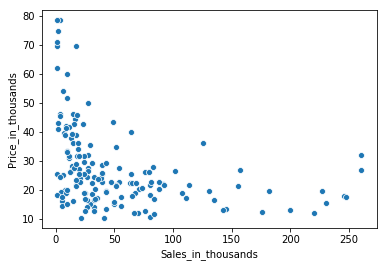

In [64]:
sns.scatterplot( cars_new.Sales_in_thousands, cars_new.Price_in_thousands)

In [ ]:
# no of obs should be greater than no of variables

# y should be linearly related with X variables

# All the variables should be normally distributed; 
# if not all, atleast y should be normally distributed


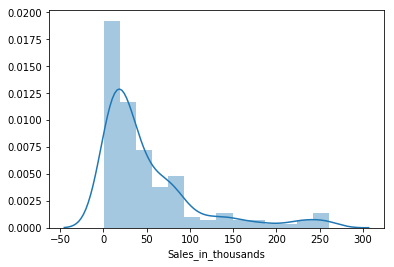

In [65]:
# Very first assumtion is that all the variables should be normally distributed, however that can't be possible
# However we have to be atleast strict about the dependant Y variable

# Distribution of variables
sns.distplot(cars_new.Sales_in_thousands)
plt.show()
# this distribution is highly skewed

# Notes:
#-----------------------------------------------------
# 1. if we get skewed data, then we have to transform the data and there are multiple methods to go about it
# 2. most commonly used and which works on most of the data is log transformation
# 3. Ideally we can do this for each of the dependant variable as well, 
#    however it will depend on amount of data and the amount of analytical rigour
# 4. In no case we can proceed if dependant variable is not normal/near to normal distributed

In [66]:
cars_new.Sales_in_thousands.skew()

1.99249329205088

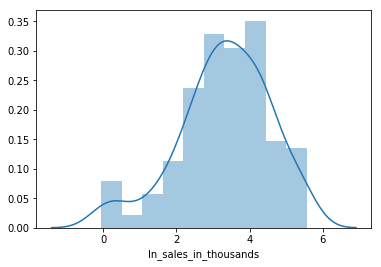

In [67]:
# Note: good practice is to take the log of the data plus 1, bcoz we don't have log of zero defined
# In thios data its not required as sales are always greater than zero

# apply log transformation: log is rescalling the data and making the distribution normal
cars_new['ln_sales_in_thousands'] = np.log(cars_new['Sales_in_thousands'])

# Distribution of variables
sns.distplot(cars_new.ln_sales_in_thousands)
plt.show()

In [68]:
cars_new.ln_sales_in_thousands.skew()

-0.5925861100519004

In [69]:
# Linearity: correlation matrix (ranges from 1 to -1)
corrm = cars_new.corr()
corrm.to_excel('corrm.xlsx')

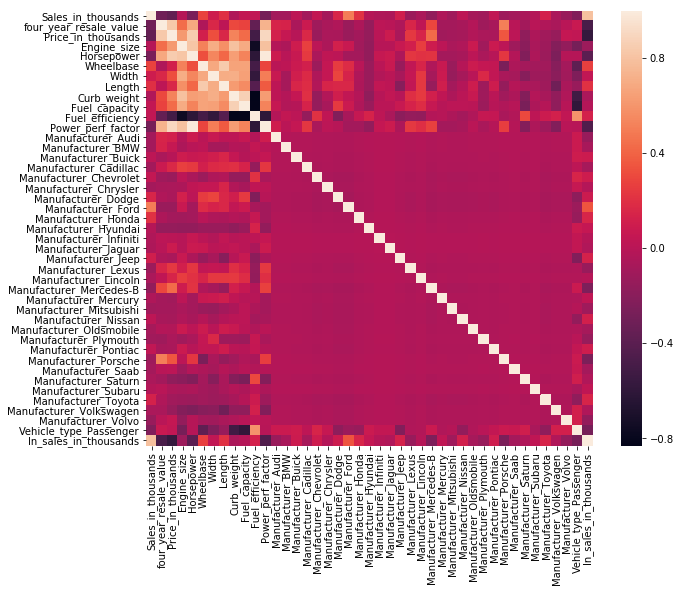

In [70]:
# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize = (10, 8))
sns.heatmap(cars_new.corr())

# fuel efficiency vs fuel capacity
# Curb weight vs Engine Size

# in case we can't make any concrete decision looking at the variables; we can also check on the VAR of 
# the variables into consideration e.g Curb weight vs Wheel base

In [71]:
# no of variables and obs in the final data to be used for modelling
cars_new.shape

(157, 43)

In [72]:
# model methods doesn't allow any special chars in varaible names except underscore
cars_new.columns

Index(['Sales_in_thousands', 'four_year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length',
       'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor',
       'Manufacturer_Audi', 'Manufacturer_BMW', 'Manufacturer_Buick',
       'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes-B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Vehicle_

In [73]:
# remove the special chars
cars_new.rename( columns = {'Manufacturer_Mercedes-B':'Manufacturer_Mercedes_B'}, inplace = True)

### feature selection based on importance using F - Regression

In [78]:
Features = cars_new.columns.difference(['ln_sales_in_thousands', 'Sales_in_thousands'])

In [79]:
Features

Index(['Curb_weight', 'Engine_size', 'Fuel_capacity', 'Fuel_efficiency',
       'Horsepower', 'Length', 'Manufacturer_Audi', 'Manufacturer_BMW',
       'Manufacturer_Buick', 'Manufacturer_Cadillac', 'Manufacturer_Chevrolet',
       'Manufacturer_Chrysler', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Hyundai', 'Manufacturer_Infiniti',
       'Manufacturer_Jaguar', 'Manufacturer_Jeep', 'Manufacturer_Lexus',
       'Manufacturer_Lincoln', 'Manufacturer_Mercedes_B',
       'Manufacturer_Mercury', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Oldsmobile',
       'Manufacturer_Plymouth', 'Manufacturer_Pontiac', 'Manufacturer_Porsche',
       'Manufacturer_Saab', 'Manufacturer_Saturn', 'Manufacturer_Subaru',
       'Manufacturer_Toyota', 'Manufacturer_Volkswagen', 'Manufacturer_Volvo',
       'Power_perf_factor', 'Price_in_thousands', 'Vehicle_type_Passenger',
       'Wheelbase', 'Width', 'four_year_resale_value'],
      dtype

In [99]:
# Feature Selection based on importance
from sklearn.feature_selection import f_regression

In [100]:
# run the F regression to get the significant variables
features = cars_new[Features]
target = cars_new['ln_sales_in_thousands']
F_values, p_values  = f_regression( features, target )

In [113]:
# get the results in the datafram
F_Regression_results = pd.concat([pd.Series(features.columns), 
                            pd.Series(F_values), pd.Series(p_values).round(5)], axis = 1)

# add the column names
F_Regression_results.columns = ['Feature', 'F_value', 'p_value']

In [184]:
F_Regression_results.sort_values(by  = 'p_value')

,Feature,F_value,p_value
40,four_year_resale_value,46.240179,0.00000
35,Power_perf_factor,38.736106,0.00000
36,Price_in_thousands,77.830710,0.00000
4,Horsepower,29.616745,0.00000
13,Manufacturer_Ford,21.061447,0.00001
37,Vehicle_type_Passenger,12.462157,0.00055
38,Wheelbase,12.207817,0.00062
28,Manufacturer_Porsche,10.653178,0.00135
21,Manufacturer_Mercedes_B,9.878573,0.00200
5,Length,6.954753,0.00921


In [116]:
# Filter the data where p is <= 0.1
Features = list(F_Regression_results.loc[ F_Regression_results.p_value <= 0.1, 'Feature' ])

In [117]:
Features

['Fuel_efficiency',
 'Horsepower',
 'Length',
 'Manufacturer_Audi',
 'Manufacturer_Ford',
 'Manufacturer_Honda',
 'Manufacturer_Mercedes_B',
 'Manufacturer_Plymouth',
 'Manufacturer_Porsche',
 'Manufacturer_Toyota',
 'Manufacturer_Volvo',
 'Power_perf_factor',
 'Price_in_thousands',
 'Vehicle_type_Passenger',
 'Wheelbase',
 'four_year_resale_value']

### Remove the multi colinear variables - VIF

In [131]:
# import the packages for vif - Variance Inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [137]:
model_param = 'ln_sales_in_thousands ~ ' + ' + '.join(Features)

In [138]:
model_param

'ln_sales_in_thousands ~ Fuel_efficiency + Horsepower + Length + Manufacturer_Audi + Manufacturer_Ford + Manufacturer_Honda + Manufacturer_Mercedes_B + Manufacturer_Plymouth + Manufacturer_Porsche + Manufacturer_Toyota + Manufacturer_Volvo + Power_perf_factor + Price_in_thousands + Vehicle_type_Passenger + Wheelbase + four_year_resale_value'

In [157]:
model_param = ''' ln_sales_in_thousands ~ Fuel_efficiency + Length + 
            Manufacturer_Audi + Manufacturer_Ford + Manufacturer_Honda + Manufacturer_Mercedes_B + 
            Manufacturer_Plymouth + Manufacturer_Porsche + Manufacturer_Toyota + 
            Manufacturer_Volvo + Price_in_thousands + 
            Vehicle_type_Passenger'''

In [158]:
# High VIF of the variable means information in that variable has already been explained by 
# other X variables present in the model

# separate the Y and X variables
y, X = dmatrices(model_param, cars_new, return_type = 'dataframe')

In [159]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Features,VIF Factor
0,Intercept,568.593937
1,Fuel_efficiency,4.016468
2,Length,1.438255
3,Manufacturer_Audi,1.056253
4,Manufacturer_Ford,1.081124
5,Manufacturer_Honda,1.085457
6,Manufacturer_Mercedes_B,1.603515
7,Manufacturer_Plymouth,1.031573
8,Manufacturer_Porsche,1.380634
9,Manufacturer_Toyota,1.150305


In [160]:
Features = list(vif.loc[ vif.Features != 'Intercept', 'Features'])

In [161]:
Features

['Fuel_efficiency',
 'Length',
 'Manufacturer_Audi',
 'Manufacturer_Ford',
 'Manufacturer_Honda',
 'Manufacturer_Mercedes_B',
 'Manufacturer_Plymouth',
 'Manufacturer_Porsche',
 'Manufacturer_Toyota',
 'Manufacturer_Volvo',
 'Price_in_thousands',
 'Vehicle_type_Passenger']

### split the data for model building

In [162]:
# method 1: divide the data into training and testing for smf
train, test = train_test_split(cars_new, test_size = 0.3, random_state = 1)

In [163]:
# method 2: divide the data into training and testing and separate out Y and X variables
# this will be used in sklearn related functions
train_X, test_X, train_y, test_y = train_test_split(cars_new[Features], 
            cars_new['ln_sales_in_thousands'], test_size = 0.3, random_state = 12345)

In [164]:
# verify the no of obs in training and testing after split
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  109  |  No of obs in testing:  48


## Form of linear regression

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors").
- And once we've learned these coefficients, we can use the model to predict the response.

### building a linear regression model

In [165]:
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Modeling Steps

In [166]:
# smf.ols(' y ~ x1 + x2 + x3 + .... + xn', train )

In [167]:
Features

['Fuel_efficiency',
 'Length',
 'Manufacturer_Audi',
 'Manufacturer_Ford',
 'Manufacturer_Honda',
 'Manufacturer_Mercedes_B',
 'Manufacturer_Plymouth',
 'Manufacturer_Porsche',
 'Manufacturer_Toyota',
 'Manufacturer_Volvo',
 'Price_in_thousands',
 'Vehicle_type_Passenger']

In [168]:
formula_m0 = 'ln_sales_in_thousands ~ ' + ' + '.join( Features )

In [178]:
formula_m0 = ''' ln_sales_in_thousands ~ Fuel_efficiency + Length + 
            Manufacturer_Ford  + 
            Manufacturer_Plymouth + 
             Price_in_thousands + Vehicle_type_Passenger'''

In [179]:
lm0 = smf.ols( formula_m0, train ).fit()

In [180]:
print(lm0.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.513
Model:                               OLS   Adj. R-squared:                  0.484
Method:                    Least Squares   F-statistic:                     17.91
Date:                   Sat, 21 Mar 2020   Prob (F-statistic):           4.33e-14
Time:                           17:37:41   Log-Likelihood:                -139.01
No. Observations:                    109   AIC:                             292.0
Df Residuals:                        102   BIC:                             310.9
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

*******************************************************************************************

# Start from here

*******************************************************************************************

### Predict the values

In [175]:
# Step 4: predict the sales on the training data
train.loc[:, 'pred_sales'] = np.exp( lm0.predict(train) )

In [181]:
# Step 5: predict the sales on the testing/validation data
test.loc[:, 'pred_sales'] = np.exp( lm0.predict(test) )

### model validation - for accuracies after predictions

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [185]:
# Step 6: 
# MAPE: Mean Absolute Percentage Error
# RMSE: Root Mean Square Error
# Decile analysis: for validation of models - Business validation

In [186]:
# a) accuracy metrics (a. MAE: Mean Absolute Error)
MAE_train = mean_absolute_error(train.Sales_in_thousands, train.pred_sales)
MAE_test = mean_absolute_error(test.Sales_in_thousands, test.pred_sales)

# print the values of MAE for train and test
print('MAE of training data: ', MAE_train,  ' | ', 'MAE of testing data: ', MAE_test)

MAE of training data:  28.894096864033813  |  MAE of testing data:  35.95525054277123


In [184]:
# Step 6: 
# b) accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAPE_train = np.mean(np.abs(train['Sales_in_thousands'] - train['pred_sales'])/train['Sales_in_thousands'])
MAPE_test = np.mean(np.abs(test['Sales_in_thousands'] - test['pred_sales'])/test['Sales_in_thousands'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  1.133529625236131  |  MAPE of testing data:  0.7722052476912662


In [188]:
# Step 6: 
# c) MSE: Mean squared Error and RMSE: Root Mean Square Error
MSE_train = mean_squared_error(train.Sales_in_thousands, train.pred_sales)
MSE_test = mean_squared_error(test.Sales_in_thousands, test.pred_sales)

# print the values of MSE for train and test
print('MSE of training data: ', MSE_train,  ' | ', 'MSE of testing data: ', MSE_test)

# print the values of RMSE for train and test
print('RMSE of training data: ', np.sqrt(MSE_train),  ' | ', 'RMSE of testing data: ', np.sqrt(MSE_test))

MSE of training data:  2455.247147207944  |  MSE of testing data:  4302.981894260402
RMSE of training data:  49.55045052477267  |  RMSE of testing data:  65.59711803319108


In [189]:
# Step 6: 
# d.1) Corelation between actual and predicted
Corr_train = stats.pearsonr(train.Sales_in_thousands, train.pred_sales)
Corr_test = stats.pearsonr(test.Sales_in_thousands, test.pred_sales)

# print the values of Corelation for train and test
print('Corr of training data: ', Corr_train,  ' | ', 'Corr of testing data: ', Corr_test)

Corr of training data:  (0.5865469802482524, 2.059049771564186e-11)  |  Corr of testing data:  (0.7175807474222512, 9.502483932963874e-09)


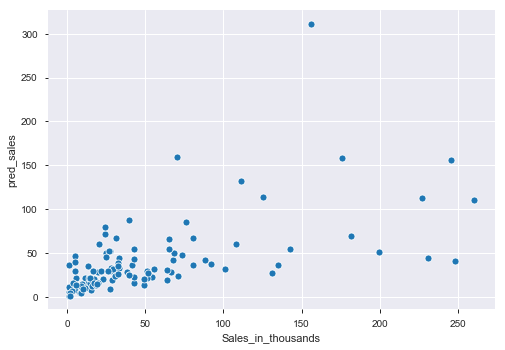

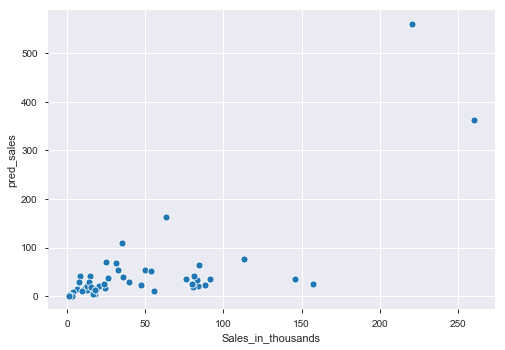

In [190]:
# Step 6: 
# d.2) Corelation between actual and predicted
sns.scatterplot(train.Sales_in_thousands, train.pred_sales)
plt.show()

sns.scatterplot(test.Sales_in_thousands, test.pred_sales)
plt.show()

In [201]:
# Step 6: 
# e) accuracy metrics (d. Decile Analysis: for validation of models - Business validation)

# create the 10 groups in the data
train.loc[:, 'Deciles'] = pd.qcut( train['pred_sales'], 10, labels = False )
test.loc[:, 'Deciles'] = pd.qcut( test['pred_sales'], 10, labels = False )

# Decile Analysis for train data
Predicted_avg_train = train.groupby('Deciles')[['Sales_in_thousands', 'pred_sales']].mean().reset_index().sort_index(ascending = False)
Predicted_avg_test = test.groupby('Deciles')[['Sales_in_thousands', 'pred_sales']].mean().reset_index().sort_index(ascending = False)

# write the data into the file
Predicted_avg_train.to_csv('Decile_analysis_train.csv')
Predicted_avg_test.to_csv('Decile_analysis_test.csv')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [202]:
Predicted_avg_train

,Deciles,Sales_in_thousands,pred_sales
9,9,137.438029,137.067274
8,8,71.691545,61.675419
7,7,72.483182,47.005810
6,6,69.982273,37.744406
5,5,43.323800,31.011054
4,4,47.016636,27.217301
3,3,28.450636,21.707183
2,2,22.605091,16.455880
1,1,15.159844,11.740551
0,0,5.382364,4.969518


In [203]:
Predicted_avg_test

,Deciles,Sales_in_thousands,pred_sales
9,9,138.627064,254.672958
8,8,44.391800,62.043022
7,7,38.684400,43.162606
6,6,84.836500,35.746035
5,5,44.885200,28.888661
4,4,65.761800,23.713561
3,3,34.845000,20.203901
2,2,27.975200,16.367561
1,1,19.941800,11.091881
0,0,7.984656,2.868208


#### validate the poor model performance due of LM assumptions

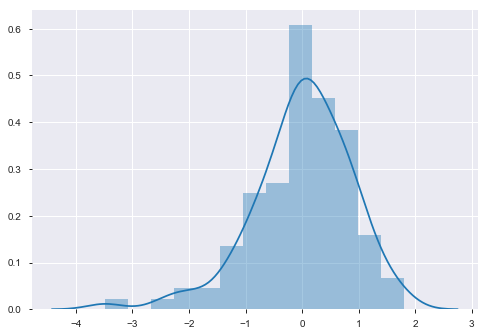

In [205]:
# assumption: Normality of the residuals/error (using distplot)
sns.distplot(lm0.resid)
plt.show()

In [206]:
# assumption: mean of residuals/errors is zero
print(lm0.resid.mean())

2.1332578924540622e-14


In [211]:
# assumption: residuals/errors of the model should not be correlated with dependant (Y) variable
print(stats.stats.pearsonr(lm0.resid, train.ln_sales_in_thousands))

(0.6886799858071819, 1.2713487518663198e-16)


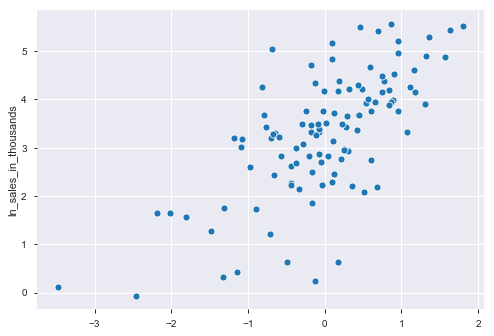

In [212]:
# assumption: homoscedasticity of residuals/errors
sns.scatterplot(lm0.resid, train.ln_sales_in_thousands)
plt.show()

#### What can be the possible reasons for poor model performance?

### Tips/guidlines for imporvement of model accuracy

### Other Reading information

### Feature selection

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use of **p-values** or **R-squared** for feature selection?

- Linear models rely upon **a lot of assumptions** (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- Features that are unrelated to the response can still have **significant p-values**.
- Adding features to your model that are unrelated to the response will always **increase the R-squared value**, and adjusted R-squared does not sufficiently account for this.
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to **directly estimate** how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a **machine learning methodology**.
- This course focuses on **general purpose approaches** that can be applied to any model, rather than model-specific approaches.

### Evaluating Model Accuracy
> R-squared is a statistical measure of how close the data are to the fitted regression line. <br>
> R-square signifies percentage of variations in the reponse variable that can be explained by the model. <br>
> - R-squared = Explained variation / Total variation <br>
> - Total variation is variation of response variable around it's mean. <br>

> R-squared value varies between 0 and 100%. 0% signifies that the model explains none of the variability, <br>
while 100% signifies that the model explains all the variability of the response. <br>
The closer the r-square to 100%, the better is the model. <br>

## Other Evaluation metrics for regression problems

Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. We need evaluation metrics designed for comparing **continuous values**.

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

## Comparing linear regression with other models

Advantages of linear regression:

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don't need scaling
- Can perform well with a small number of observations
- Well-understood

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response
- Performance is (generally) not competitive with the best supervised learning methods due to high bias
- Can't automatically learn feature interactions